In [1]:
import sys
sys.path.insert(1,'./decoders')
sys.path.insert(1,'./Instances_models')
sys.path.insert(1,'./Evaluators')
sys.path.insert(1,'./Utils')
from TSP_decoder import TSPDecoder
from TSP_instance import TSPInstance
from Datasets import FNN_dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os    
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

burma14 : 3323

In [2]:
instance  = TSPInstance(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Instances_data_TSP\burma14.dat')
decoder = TSPDecoder(instance)

In [3]:
chromossomes = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\chromosomes_1.txt')
fitness = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\fitness_1.txt')
lista = [chromossomes,fitness]


In [4]:
print(len(chromossomes))

10000


In [5]:
tours = np.zeros((len(chromossomes),14))
for i in np.arange(len(chromossomes)):
    tours[i] = np.argsort(chromossomes[i]) 
    

In [6]:
print(tours[3])

[ 2.  3.  9.  7.  8. 12.  5.  4.  1. 10.  0.  6. 13. 11.]


In [7]:
init_pop = pd.DataFrame(data=chromossomes)

In [8]:
init_pop['Fitness'] = fitness

In [9]:
print(f'maximo: {fitness.max()}  minimo {fitness.min()}')

maximo: 8829.0  minimo 4176.0


In [10]:
best = np.argsort(fitness)
print(best[0:3])

[8141 8542 9106]


In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(tours,fitness,test_size=0.2,random_state=42)



In [12]:
class Population_dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float)
        self.y = torch.tensor(y,dtype=torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        chromossome = self.x[idx]
        fit = self.y[idx]
        return chromossome,fit
    

In [13]:
class VAautoencoder(nn.Module):
    def __init__(self,input_dim,h_dim,z_dim):
        super().__init__()
        
        self.fitness = nn.Linear(z_dim,1 )
        #encoder
        self.recorrente_encoder = nn.LSTM(input_dim,h_dim,num_layers=3,batch_first=True)
        
        self.sigma = nn.Linear(h_dim,z_dim)
        self.mu = nn.Linear(h_dim,z_dim)

        #decode
        self.LSTM_decoder = nn.LSTM(z_dim,h_dim ,num_layers=3,batch_first=True)
        self.z_2hidden = nn.Linear(z_dim,h_dim)
        self.output = nn.Linear(h_dim,input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    
    def encode(self,x):
        x = torch.unsqueeze(x,2)
        saida,(h_n,c_n) = self.recorrente_encoder(x)
        h_n = h_n[-1]
        mu = self.mu(h_n)
        sigma = self.sigma(h_n)
        return mu ,sigma
    
    def decode(self,z):
        out,hidden = self.LSTM_decoder(z)
        output = self.output(out)
        return output
    
    def forward(self,x):
        mu,sigma = self.encode(x)
        epsilon = torch.rand_like(sigma)
        z_reparametrizado = mu + torch.exp(sigma/2)*epsilon
        pred_value = self.fitness(z_reparametrizado)
        x_reconstruido = self.decode(z_reparametrizado)
        return x_reconstruido,mu,sigma,pred_value
        

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMPUT_DIM = 14
H_DIM = 10
Z_DIM = 7
NUM_EPOCH = 500
LA_RATE = 3e-3

In [15]:
modelVAE = VAautoencoder(IMPUT_DIM,H_DIM,Z_DIM)
optimizerVAE = torch.optim.Adam(modelVAE.parameters(),lr=LA_RATE)
Cross_Entropy_Loss = nn.CrossEntropyLoss()
MSE_Loss = nn.MSELoss()
loss_per_epoch_VAE = np.zeros(NUM_EPOCH)
prediction_loss = np.zeros(NUM_EPOCH)

In [16]:
train_dataset = Population_dataset(X_train,Y_train)
test_dataset = Population_dataset(X_test,Y_test)

train_dataloader = DataLoader(train_dataset,batch_size=100,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=False)

In [17]:

def train_model(model,optimizer,Cross_Entropy_Loss,MSE_Loss,NUM_EPOCH,dataloader,loss_per_epoch,prediction_loss):
    for epoch in range(NUM_EPOCH):
        for index, (x,y) in enumerate(dataloader):
            
            x_reconstructed, mu, sigma,pred = model(x)
    

 
            
            x_tour = np.argsort(x_reconstructed.detach().numpy())
            x_tour = torch.tensor(x_tour,dtype=torch.float)
            #print(x_tour.shape)
            x = x.type(torch.float)
            recons_loss= Cross_Entropy_Loss(x_tour,x)
            
            
            kl_div = -0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            pred = torch.squeeze(pred,dim=1)
            fit_error = MSE_Loss(pred,y)
            
            optimizer.zero_grad() 
            loss_val = recons_loss + kl_div  + fit_error
            
            loss_val.backward()
            optimizer.step()
            
            loss_per_epoch[epoch] = loss_val 
            prediction_loss[epoch] = fit_error
            
            
        if epoch % 100 ==0:   
            print(f"Epoch {epoch}, Erro Treino: {loss_per_epoch[epoch]}")
            
            

In [18]:

train_model(modelVAE,optimizerVAE,Cross_Entropy_Loss,MSE_Loss,NUM_EPOCH,train_dataloader,loss_per_epoch_VAE,prediction_loss)

Epoch 0, Erro Treino: 44762096.0
Epoch 100, Erro Treino: 1549636.375
Epoch 200, Erro Treino: 581591.625
Epoch 300, Erro Treino: 299326.3125
Epoch 400, Erro Treino: 186629.375


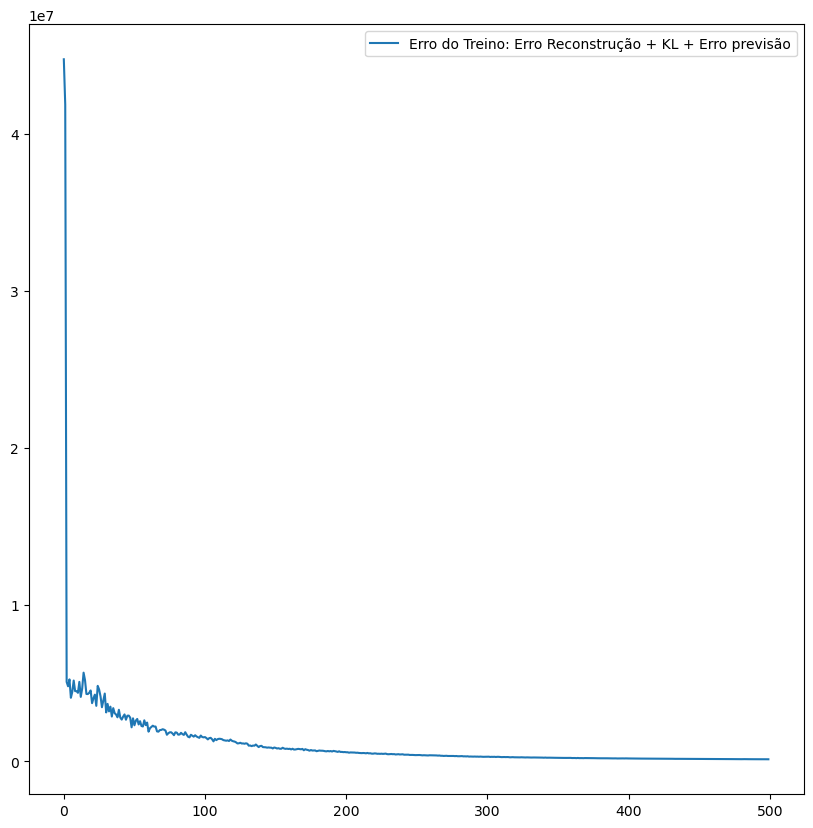

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(loss_per_epoch_VAE, label='Erro do Treino: Erro Reconstrução + KL + Erro previsão')
plt.legend()
plt.show()

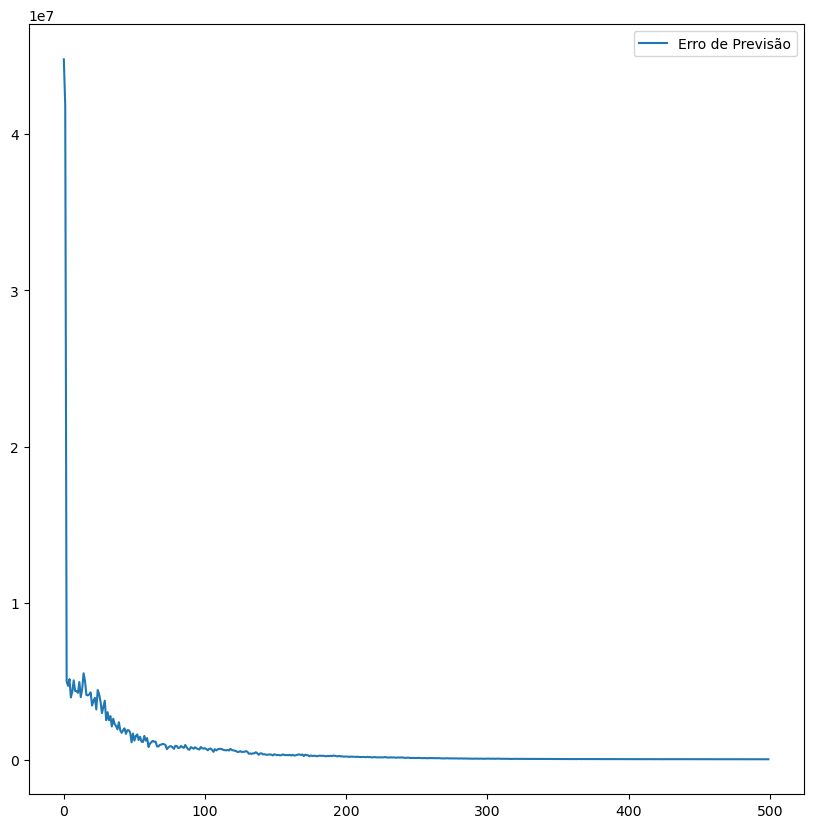

In [20]:
plt.figure(figsize=(10,10))
plt.plot(prediction_loss, label='Erro de Previsão')
plt.legend()
plt.show()

In [21]:
with torch.no_grad():
    mu,sigma = modelVAE.encode(torch.tensor(X_train,dtype=torch.float))
    epsilon = torch.randn_like(sigma)
    z_train = mu + torch.exp(sigma/2)*epsilon
    

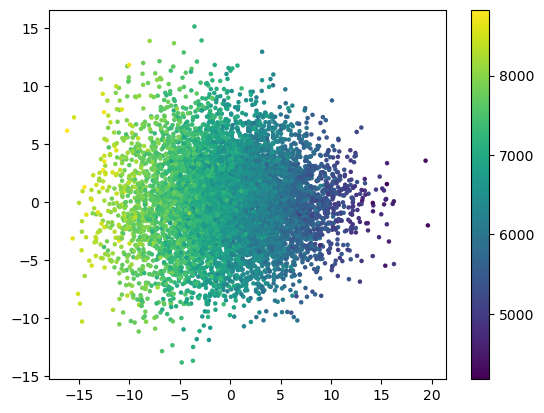

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(z_train)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=Y_train, cmap='viridis', s=5)
plt.colorbar()
plt.show()

In [23]:
pca.explained_variance_ratio_

array([0.40959904, 0.21541684])